In [2]:
import time
import torch
import requests
import pandas as pd
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor, as_completed

In [ ]:
def fetch_movies_for_year(api_key, year):
    movies = []
    page = 1
    while True:
        url = f'https://api.themoviedb.org/3/discover/movie?api_key={api_key}&page={page}&language=en-US&primary_release_year={year}'
        response = requests.get(url)
        data = response.json()

        if 'results' in data:
            movies.extend(data['results'])

            if page >= data.get('total_pages', 1) or len(movies) >= 10000:
                break
            page += 1
        else:
            print(f'Error fetching data for year {year}')
            break
        time.sleep(0.1)
    return movies

def get_movies(api_key, start_year, end_year):
    movies = []
    years = range(start_year, end_year + 1)
    with ThreadPoolExecutor(max_workers=5) as executor:
        future_to_year = {executor.submit(fetch_movies_for_year, api_key, year): year for year in years}
        for future in as_completed(future_to_year):
            year = future_to_year[future]
            try:
                yearly_movies = future.result()
                for movie in yearly_movies:
                    movie['release_year'] = year  
                movies.extend(yearly_movies)
                print(f'Fetched {len(yearly_movies)} movies for {year}')
            except Exception as exc:
                print(f'{year} generated an exception: {exc}')
    return movies


api_key = 'b4d3bebe67b3b8135ee1a697673dedca'
movies = get_movies(api_key, 1990, 2020)

df = pd.DataFrame(movies)
df.to_csv('new_movies.csv', index=False)
print(f"Total movies saved: {len(df)}")


# EDA

First 20 Samples:

+---------+----------------------------------+---------------------+--------+---------------------+-------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------+----------------------------------+----------------+-------------------------------------------------------------------+---------+----------------+--------------+----------------+
| adult   | backdrop_path                    | genre_ids           

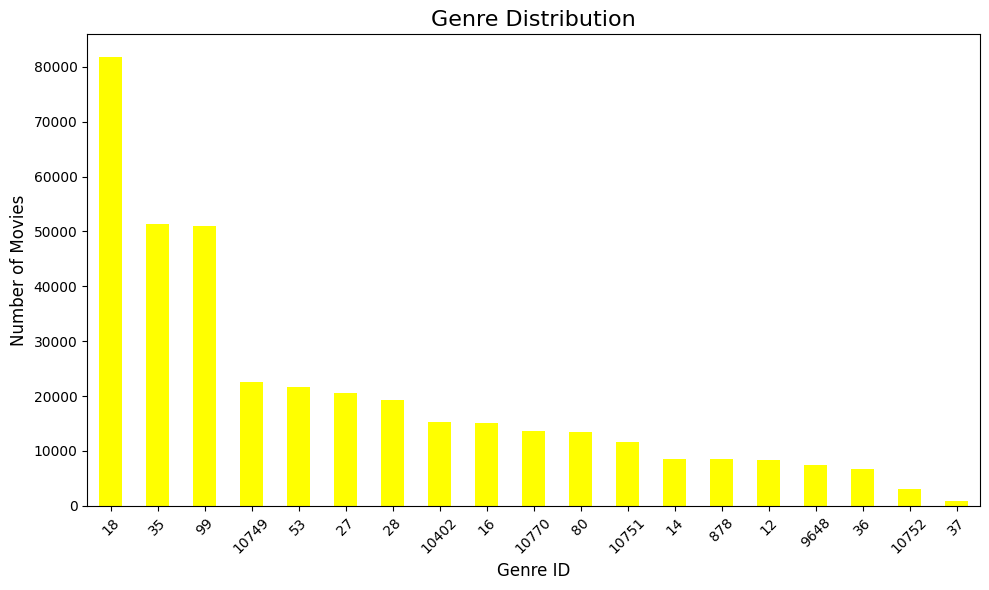

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
from tabulate import tabulate  


df = pd.read_csv('new_movies.csv')


print("First 20 Samples:\n")
print(tabulate(df.head(20), headers='keys', tablefmt='grid', showindex=False))


df['genre_ids'] = df['genre_ids'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])


all_genres = [genre_id for sublist in df['genre_ids'] for genre_id in sublist]

genre_counts = pd.Series(all_genres).value_counts()

plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar', color='yellow')
plt.title("Genre Distribution", fontsize=16)
plt.xlabel("Genre ID", fontsize=12)
plt.ylabel("Number of Movies", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


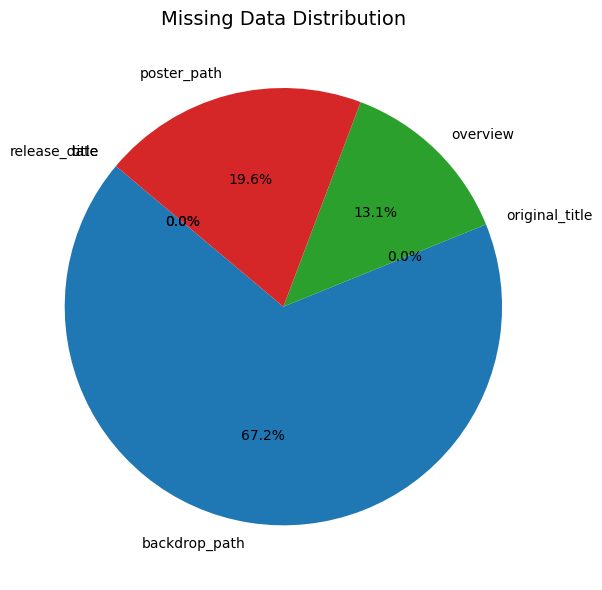

In [4]:

df = pd.read_csv('new_movies.csv')

missing_counts = df.isnull().sum()

missing_counts = missing_counts[missing_counts > 0]


if not missing_counts.empty:
    plt.figure(figsize=(8, 6))
    plt.pie(
        missing_counts,
        labels=missing_counts.index,
        autopct='%1.1f%%',
        startangle=140
    )
    plt.title("Missing Data Distribution", fontsize=14)
    plt.tight_layout()
    plt.show()
else:
    print(" No missing data found in the dataset.")


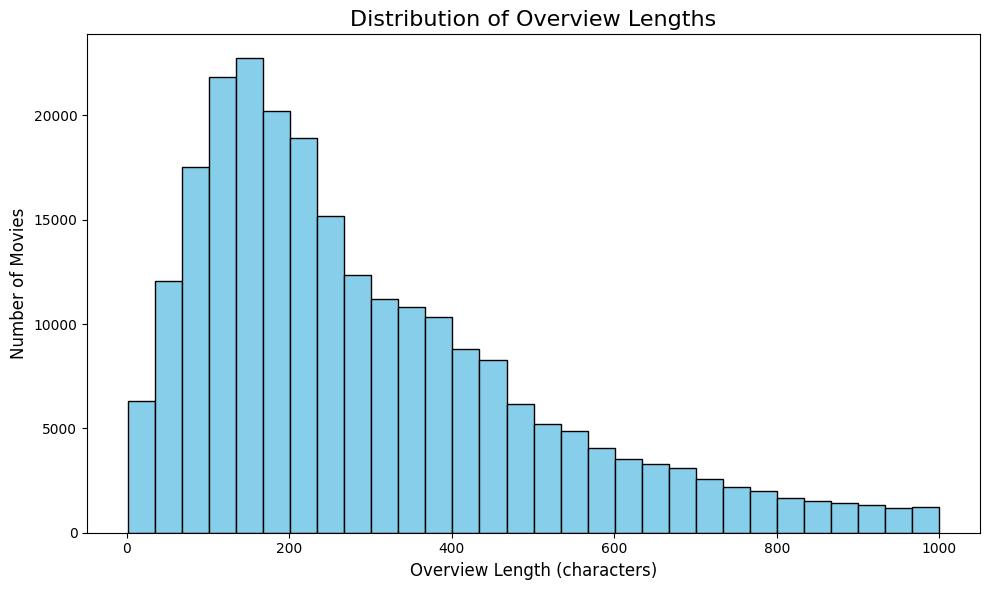

In [ ]:
df = pd.read_csv('new_movies.csv')
df = df.dropna(subset=['overview'])
df['overview_length'] = df['overview'].apply(len)

plt.figure(figsize=(10, 6))
plt.hist(df['overview_length'], bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Overview Lengths", fontsize=16)
plt.xlabel("Overview Length (characters)", fontsize=12)
plt.ylabel("Number of Movies", fontsize=12)
plt.tight_layout()
plt.show()


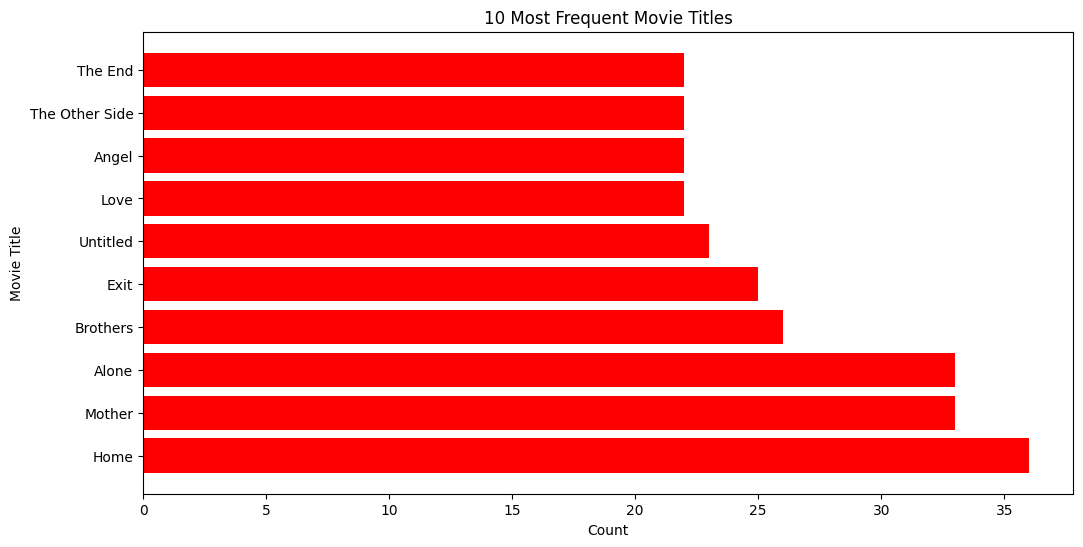

In [6]:
if 'title' in df.columns:
    # Count the number of times each title appears
    title_counts = {}

    for title in df['title']:
        if title in title_counts:
            title_counts[title] += 1
        else:
            title_counts[title] = 1

    # Sort the titles by frequency (in descending order)
    sorted_titles = sorted(title_counts.items(), key=lambda x: x[1], reverse=True)

    # Take the most frequent titles
    TitleAmount = 10
    top_titles = sorted_titles[:TitleAmount]

    titles = [x[0] for x in top_titles]
    counts = [x[1] for x in top_titles]

    plt.figure(figsize=(12, 6))
    plt.barh(titles, counts, color='red')
    plt.title(f"{TitleAmount} Most Frequent Movie Titles")
    plt.xlabel("Count")
    plt.ylabel("Movie Title")
    plt.show()
else:
    print("Error")


# Balancing dataset

In [ ]:
import pandas as pd
import ast
from sklearn.utils import resample


df = pd.read_csv('new_movies.csv')
df['genre_ids'] = df['genre_ids'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

all_genres = [g for sublist in df['genre_ids'] for g in sublist]
genre_counts = pd.Series(all_genres).value_counts()

STRICT_TARGET = 5000

balanced_df = pd.DataFrame()

for genre in genre_counts.index:
    genre_df = df[df['genre_ids'].apply(lambda genres: genre in genres)]

    if len(genre_df) < STRICT_TARGET:
        genre_df_balanced = resample(genre_df, replace=True, n_samples=STRICT_TARGET, random_state=42)
    else:
        genre_df_balanced = genre_df.sample(n=STRICT_TARGET, random_state=42)

    balanced_df = pd.concat([balanced_df, genre_df_balanced])

balanced_df['genre_ids'] = balanced_df['genre_ids'].apply(lambda x: str(x))
balanced_df = balanced_df.drop_duplicates()
balanced_df['genre_ids'] = balanced_df['genre_ids'].apply(lambda x: ast.literal_eval(x))

balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

balanced_df.to_csv('new_movies_perfectly_balanced.csv', index=False)

print(f"Final perfectly balanced dataset size: {len(balanced_df)}")


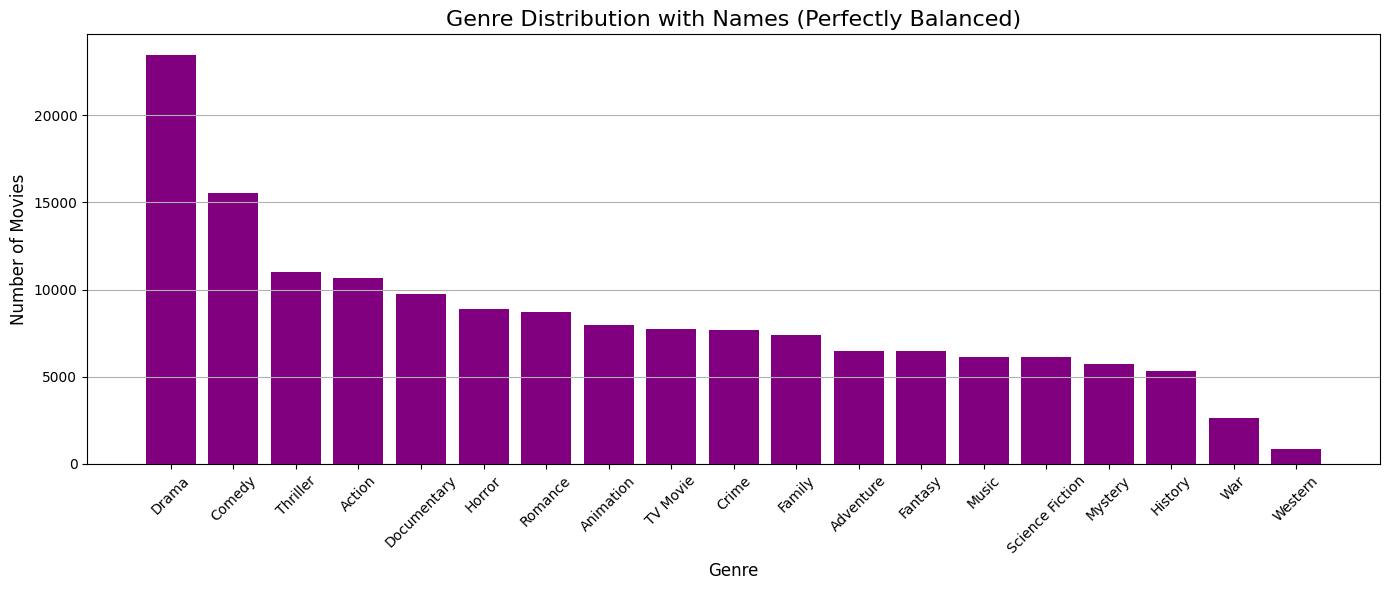

In [7]:
import pandas as pd
import ast
import matplotlib.pyplot as plt

genre_id_to_name = {
    28: "Action",
    12: "Adventure",
    16: "Animation",
    35: "Comedy",
    80: "Crime",
    99: "Documentary",
    18: "Drama",
    10751: "Family",
    14: "Fantasy",
    36: "History",
    27: "Horror",
    10402: "Music",
    9648: "Mystery",
    10749: "Romance",
    878: "Science Fiction",
    10770: "TV Movie",
    53: "Thriller",
    10752: "War",
    37: "Western"
}

df_balanced = pd.read_csv('new_movies_perfectly_balanced.csv')
df_balanced['genre_ids'] = df_balanced['genre_ids'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

all_genres = [g for sublist in df_balanced['genre_ids'] for g in sublist]
genre_counts = pd.Series(all_genres).value_counts()

genre_names = [genre_id_to_name.get(genre_id, str(genre_id)) for genre_id in genre_counts.index]

plt.figure(figsize=(14, 6))
plt.bar(genre_names, genre_counts.values, color='purple')
plt.title("Genre Distribution with Names (Perfectly Balanced)", fontsize=16)
plt.xlabel("Genre", fontsize=12)
plt.ylabel("Number of Movies", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


# Splitting the data

In [ ]:
import pandas as pd
import ast
from sklearn.model_selection import train_test_split

df = pd.read_csv('new_movies_perfectly_balanced.csv')
df['genre_ids'] = df['genre_ids'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

genre_id_to_name = {
    28: 'Action',
    12: 'Adventure',
    16: 'Animation',
    35: 'Comedy',
    80: 'Crime',
    99: 'Documentary',
    18: 'Drama',
    10751: 'Family',
    14: 'Fantasy',
    36: 'History',
    27: 'Horror',
    10402: 'Music',
    9648: 'Mystery',
    10749: 'Romance',
    878: 'Science Fiction',
    10770: 'TV Movie',
    53: 'Thriller',
    10752: 'War',
    37: 'Western'
}

for genre_id, genre_name in genre_id_to_name.items():
    df[genre_name] = df['genre_ids'].apply(lambda genres: int(genre_id in genres))

final_df = df[['overview'] + list(genre_id_to_name.values())]

final_df = final_df.dropna(subset=['overview']).reset_index(drop=True)

train_df, temp_df = train_test_split(final_df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

train_df.to_csv('train_balanced_clean.csv', index=False)
val_df.to_csv('val_balanced_clean.csv', index=False)
test_df.to_csv('test_balanced_clean.csv', index=False)

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")
print(" Cleaned and split successfully!")


<Figure size 1200x500 with 0 Axes>

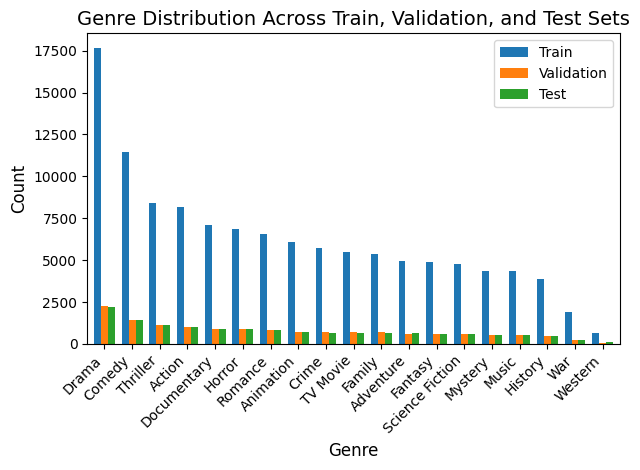

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

train_df = pd.read_csv('train_balanced_clean.csv')
val_df = pd.read_csv('val_balanced_clean.csv')
test_df = pd.read_csv('test_balanced_clean.csv')

genre_columns = [col for col in train_df.columns if col != 'overview']

train_counts = train_df[genre_columns].sum()
val_counts = val_df[genre_columns].sum()
test_counts = test_df[genre_columns].sum()

genre_df = pd.DataFrame({
    'Train': train_counts,
    'Validation': val_counts,
    'Test': test_counts
})

genre_df = genre_df.sort_values(by='Train', ascending=False)

plt.figure(figsize=(12, 5))
genre_df.plot(kind='bar', width=0.75)
plt.title("Genre Distribution Across Train, Validation, and Test Sets", fontsize=14)
plt.xlabel("Genre", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
